<h1><center>
E-commerce — clustering klients
<br>
for the online store of household goods.
</center></h1>

___

link to dashboard: https://public.tableau.com/views/Tovary_dlya_doma/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

**Tasks:**

* Segment customers by consumption profile.
* Customer: internal marketing department.
* Goal: building a personalized advertising promotion.

**Work plan**

1. **Data preprocessing:**
- reading the dataset,
    - checking the amount of data (number of rows, columns),
    - checking and correcting data types (dates, numbers, etc.),
    - working with passes,
    - work with duplicates (do not forget to lower case).
    
    
2. **Research data analysis:**
- Work with quantitative features:
        - construction of histograms by revenue,
        - building boxplot by revenue, by average check,
        - identification of emissions, anomalies, their removal or replacement,
        - checking for correlations of signs
    - Working with categorical features:
        - grouping of products by categories,
        - grouping by customers, by orders,
- search for top active users, top popular products
        - identification of the period of data provided,
        - plotting and finding patterns:
            - revenue in terms of customers, categories, time (month, year, season),
            - average receipt in terms of customers, categories, time (month, year, season),
            - number of sales
            - how often do customers buy in the store
            
            
3. **Clustering of customers with the use of machine learning**:
- selection of features by which we will cluster (average receipt, number of goods, season in the format (1-4), number of orders),
    - standardization of data,
    - building a dendogram based on customer ids to identify the optimal number of clusters,
    - apply the `k_means` model with the optimal number of clusters (set random_state = 23),
- compare cluster averages, formulate distinctive features of each cluster's clients
    
    

4. **Statistical hypothesis testing**:
- formulation of null and alternative hypotheses:
        -H0 - There are no differences in the average check between clusters,
        -H1 - There are differences in the average check between clusters.
    - checking for statistically significant differences in averages (for example, cf. check) in clusters.
    
    
5. **Formulation of conclusions and recommendations for marketing promotion**


6. **Preparation of a fianl presentation based on the results of the study**

**Data description:**

The dataset describes the transactions of an online store of household goods "While still here."

Columns in *e commerce_dataset.csv* :

- `date' — order date;
- `customer_id' — buyer's ID;
- `order_id' — order ID;
- `product` — product name;
- `quantity` — quantity of the product in the order;
- `price` — the price of the product.

## Data preprocessing

In [1]:
#importing all libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import dendrogram, linkage 

from sklearn.cluster import KMeans
import itertools
from itertools import *

from sklearn.metrics import silhouette_score

from scipy import stats as st

In [2]:
#reading the data. The dataframe consists of 74 rows and 6 columns
google_id = "1DkqEQWZoHh22YrsYcNUxSzlhgFqdl0tf"
df = pd.read_csv(f"https://drive.google.com/uc?export=download&id={google_id}" )
pd.set_option('display.max_colwidth', None)
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [3]:
#let's look at the types and omissions. There are no omissions, and the date must be converted to the date type, the other types correspond to the data, 
# we will not change it.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [4]:
#changing the date format
df['date'] = df['date'].map(lambda x: pd.to_datetime(str(x), format='%Y%m%d%H'))

In [5]:
#let's check for simple duplicates 
#first, we will reduce all string values to lowercase
df['product'] = df['product'].str.lower()

#there are no simple duplicates
display(df.duplicated().sum())
#there are quite a large number of duplicates if you do not take into account the date. i.e. the same order was made on different dates. 
##since this is due to the duplication of information coming from different systems, it is necessary to delete them
display(df.duplicated(['customer_id','order_id','product','quantity','price']).sum())

0

1864

In [6]:
#let's look at the duplicated values
df[df.duplicated(['customer_id','order_id','product','quantity','price'])].sort_values(by=['date', 'customer_id','order_id','product']).head(10)

,date,customer_id,order_id,product,quantity,price
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 см металлическая сетка 35748w,1,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 см металлическая сетка 35748w,1,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 см металлическая сетка 35748w,1,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 см металлическая сетка 35748w,1,3299.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,1409.0
126,2018-10-07 17:00:00,ce0e0c29-8c8b-4714-84bd-80957224d4cf,68557,сумка-тележка хозяйственная gimi market синяя,1,1874.0
147,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 15,0 л пищевой овальный ""ekko"" 2775, 1404032",1,209.0
148,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 18,0 л пищевой (иж), 1404047",1,194.0
149,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 20,0 л пищевой (минеральные воды), 1404045",1,277.0
150,2018-10-08 19:00:00,3de09660-90bc-4a28-aaf1-34c8435fe59c,68574,"таз пластмассовый 24,0 л пищевой круглый (иж), 1404006",1,239.0


In [7]:
#let's delete the duplicates and look at the size of the cleared dataset
df.drop_duplicates(['order_id','product','quantity'], inplace=True)
df.shape

(5574, 6)

In [8]:
#check for orders with multiple buyers.
df.groupby('order_id')['customer_id'].nunique().sort_values().tail()

order_id
70079     1
70080     1
70087     1
112789    1
69485     2
Name: customer_id, dtype: int64

In [9]:
# there is one such order left
df.query('order_id == 69485')

,date,customer_id,order_id,product,quantity,price
1282,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,набор столовых приборов 24 предмета saint germain domenik dm9638,1,1087.0
1292,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,набор столовых приборов 24 предмета farandole domenik dm9635,1,1274.0


In [10]:
## let's look at the buyers. This made 2 purchases
df.query('customer_id == "5be0f4b4-947f-4672-b147-73ef5936ecd4"')

,date,customer_id,order_id,product,quantity,price
1282,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,набор столовых приборов 24 предмета saint germain domenik dm9638,1,1087.0
6883,2019-11-22 01:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,108188,сушилка для белья ника сб2 20 м,1,742.0


In [11]:
## let's look at the buyers. This one made 1 purchase. Sacrifice them.
df.query('customer_id == "266beb08-ec9b-43b4-89bb-ac60fa23ffee"')

,date,customer_id,order_id,product,quantity,price
1292,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,набор столовых приборов 24 предмета farandole domenik dm9635,1,1274.0


In [12]:
#we will remove one buyer
df=df.query('customer_id != "266beb08-ec9b-43b4-89bb-ac60fa23ffee"')
df.shape

(5573, 6)

## Exploratory data analysis

### **Working with quantitative attributes**

In [13]:
#there are only two quantitative signs in the data - the number of goods in the price.
#the average number of items in the order is 1, the average price is 150
df[['quantity','price']].describe()

,quantity,price
count,5573.000000,5573.000000
mean,2.589449,530.400697
std,16.446931,973.013278
min,1.000000,9.000000
25%,1.000000,90.000000
50%,1.000000,150.000000
75%,1.000000,524.000000
max,1000.000000,14917.000000


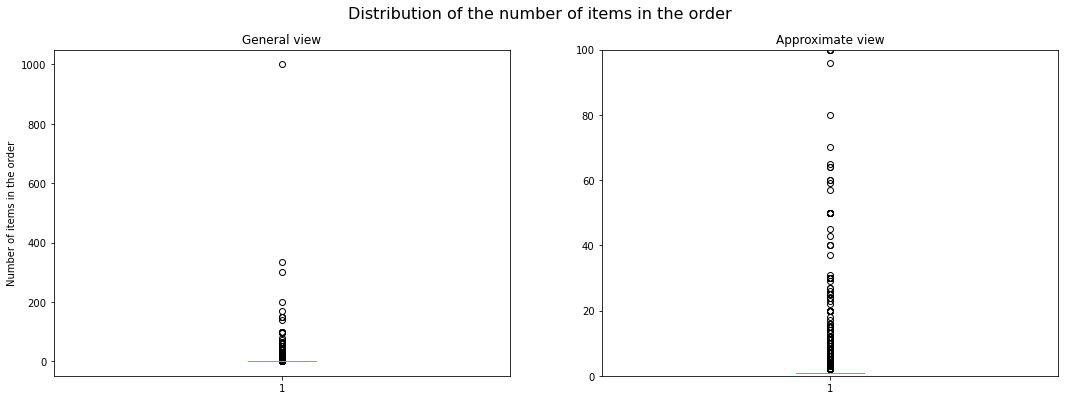

In [14]:
#very large maximum values, check for outliers
f, ax = plt.subplots(1, 2)
f.set_size_inches(18, 6) 
f.suptitle("Distribution of the number of items in the order", fontsize=16)
ax[0].boxplot(df['quantity'])
ax[0].set_title("General view")
ax[0].set_ylabel('Number of items in the order')
ax[1].boxplot(df['quantity'])
ax[1].set_ylim(0,100)
ax[1].set_title("Approximate view")
plt.show();

In [15]:
#let's look at the orders by sorting the number of orders in descending order.
df.sort_values(by='quantity', ascending=False)

,date,customer_id,order_id,product,quantity,price
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, burstenmann, 0522/0000",1000,675.0
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51.0
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,29.0
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0
...,...,...,...,...,...,...
2419,2019-03-21 14:00:00,036d75ea-b633-41a8-8974-3f84fee8c65e,70822,tepмокружка avex freeflow 700 мл зеленый avex0759,1,2399.0
2416,2019-03-21 10:00:00,c5f02bbf-06af-4e13-a9c8-eade29210b79,70819,пеларгония розебудная prins nikolai укорененный черенок,1,134.0
2415,2019-03-21 10:00:00,ee817abe-f94c-4dc8-8473-69bde144ff23,70818,"гладильная доска ника лина 1 112х34,5 см дл1",1,652.0
2413,2019-03-20 22:00:00,1c6bdff3-29ba-4241-8b03-5c1aae217c8e,70814,"сковорода hard 28 см, алюминиевая, с антипригарным покрытием, attribute, afd028",1,712.0


In [16]:
#someone decided to buy a wholesale batch of plungers, since the store is retail, we will remove this line
df=df[df['quantity'] != 1000]

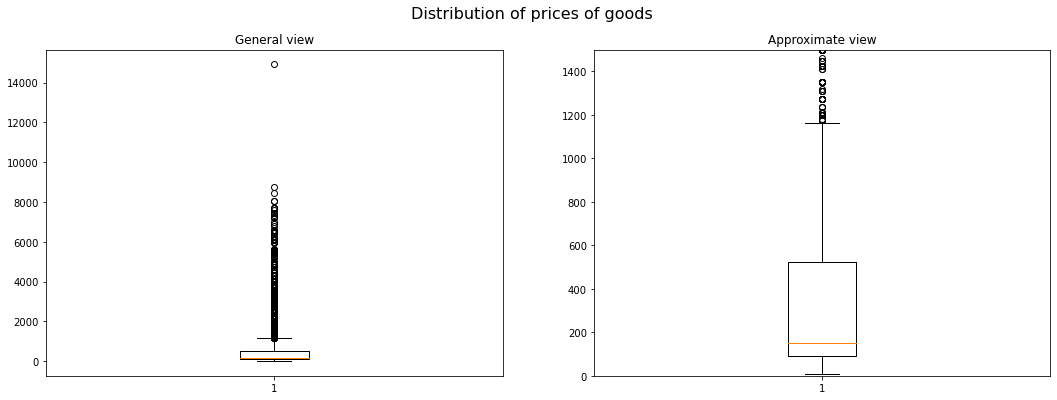

In [17]:
#there are large maximum values, let's check the price data for outliers
f, ax = plt.subplots(1, 2)
f.set_size_inches(18, 6) 
f.suptitle("Distribution of prices of goods", fontsize=16)
ax[0].boxplot(df['price'])
ax[0].set_title("General view")
ax[1].boxplot(df['price'])
ax[1].set_ylim(0,1500)
ax[1].set_title("Approximate view")
plt.show();

In [18]:
#let's look at the orders by sorting the prices in descending order. 
#it doesn't look like an anomaly, so we leave it.
df.sort_values(by='price', ascending=False)

,date,customer_id,order_id,product,quantity,price
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237 см зеленая,1,14917.0
2697,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,"сумка-тележка хозяйственная andersen royal shopper, hera, синяя 166-004-90",1,8737.0
1981,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,"сумка-тележка хозяйственная andersen alu star shopper, hava, синяя 115-103-90",1,8437.0
7436,2020-01-26 19:00:00,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,сумка-тележка хозяйственная rolser mnb019 rojo logic dos+2 красная,1,8077.0
2997,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,сумка-тележка хозяйственная rolser mnb019 rojo logic dos+2 красная,1,8077.0
...,...,...,...,...,...,...
5642,2019-07-03 22:00:00,1ec1ad59-a29b-4949-929d-f4fc4fe14758,14887,"алиссум (лобулярия) снежные одежды 0,2 г 4650091480302",1,9.0
7073,2019-12-17 12:00:00,1f7a71e2-0e7a-47ee-89d8-320b6315f4c7,107078,"львиный зев волшебный ковер 0,05 г 4660010779639",1,9.0
1069,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"алиссум (лобулярия) снежные одежды 0,2 г 4650091480302",2,9.0
2159,2019-03-04 15:00:00,0f47231c-3a68-404a-88f7-08a4a172c17f,14559,"горох амброзия 10,0 г 4660010772616",1,9.0


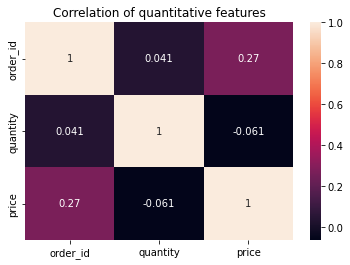

In [19]:
#we don't see strong correlations
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation of quantitative features');

### **Working with categorical features**

In [20]:
#Our task is to break the products into categories, using keywords
#let's try to find the most common words in the dataset and then use these words as keywords 
#to define a category
#it seems it will be enough to use the first two words in the product description

words = df['product'].str.split(expand=True)[[0,1]]

# remove prepositions and abbreviations
words[0] = words[0].apply(lambda x: x if len(x) > 3 else ' ')
words[1] = words[1].apply(lambda x: x if len(x) > 3 else ' ')

#let's combine into one list and count how often words occur in descriptions
words_list = words[0]+' '+ words[1]
words_list = pd.Series(words_list).value_counts().reset_index()
words_list.columns=['key_words', 'count']
words_list['key_words'] = words_list['key_words'].str.strip(' ')
words_list.head(10)

,key_words,count
0,пеларгония зональная,389
1,сушилка,298
2,пеларгония розебудная,255
3,рассада зелени,236
4,томата (помидор),168
5,гладильная доска,137
6,сумка-тележка хозяйственная,135
7,сумка-тележка,112
8,герань домашняя,112
9,чехол,99


In [21]:
#let's check that we haven't lost anything. 7474 matches the original length of the table
words_list['count'].sum()

5572

In [22]:
#create a dictionary for categories and keywords for them. I still had to view the products manually in addition to the keywords
dictionary = {'Текстиль':['полотенце','ковер','постельное','штора','коврик','хлопок','плед','скатерт','подушк','ковров',\
                         'ковёр','одеяло','халат','ткань','покрывал','одежд'],
                            
             'Мебель, инструменты':['полки','стремянк', 'крепеж','сверл','комод','этажерк','инструм','мебель','стеллаж'],
              
             'Посуда, кухня':['стакан','контейнер','салатник','тарелк','сковород','столов','ложк','нож','кружек','фужер','кувшин',\
                       'толкушк','чайник','банк','противень','посуд','кружк','чайны','рыбочистк','губка','выпечк',\
                      'кондитер','бокал','дуршлаг','термос','блюдц','бульон','разделочная доска','кастрюл','хлеб','кастрюл',\
                      'скалк','венчик','сито','миск','торт','блюд','терка','сотейник','яйц','сахарн','фарфор','бидон',\
                    'просеиватель','ковш'],
              
             'Декор':['искусственн', 'муляж','карниз','фоторамк','картин','декор','салфет','кашпо'],
              
              
             'Бытовая техника':['электр','миксер','светильник','овощеварк','овощечистк','фен дорожный','варка','мялка','весы',\
                               'свч','пылесос','утюг','соковыжималк'],
              
             'Хозтовары':['гладильн','корзин','термометр','щетк','подкладк','вешал','плечики','крючок','крючк','чехол','хранен',\
                      'крем','подрукавник','зубная','швабр','ведр','обув','почтов','сметка','измерител','линейк',\
                      'подголовник','веник','маска','сушилка','креплен','фиксатор','скребок','шпагат','окномойка','шнур',\
                      'веревк','мешок','сетка','совок','форточн','лоток','белья','прищеп','оконн','котел',\
                         'урн','полировк','бензин','перчатк'],
              
              'Cумки':['сумк','тележк'], #I will display a separate category for bags, because the revenue for them is comparable to the revenue of the whole category#
              
              'Сантехника, бытовая химия':['унитаз','ёрш','туалет','дозатор','мыло', 'ванной', 'сантех','мытья','вантуз','жиров',\
                                         'отбеливат']}

In [23]:
def category (df):
    
    '''a function for determining the product category. Accepts a dataframe column with a description of the product as input,
    it cycles through the dictionary with keywords and the category name and returns the category name. 
    If there is no match by keywords - returns the category Garden and vegetable garden'''
    
    for key, values in dictionary.items():
        for i in values:
            if i in df:
                return key
    else:
        return 'Сад и огород'

In [24]:
#apply the function to the product column and create a new column - category
df['category'] = df['product'].apply(category)

,category,product
5,Сад и огород,977
8,Хозтовары,445
4,"Посуда, кухня",279
7,Текстиль,231
2,Декор,175
0,Cумки,106
3,"Мебель, инструменты",66
1,Бытовая техника,30
6,"Сантехника, бытовая химия",30


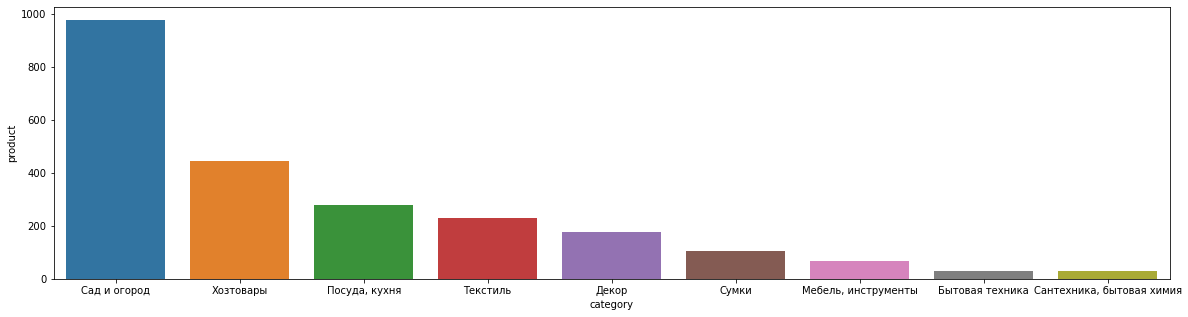

In [25]:
#Let's look at the distribution of the number of products by groups. Garden and vegetable garden with the largest number of goods
temp = df.groupby('category', as_index=False)['product'].nunique().sort_values(by='product', ascending=False)
display(temp)
plt.figure(figsize=(20,5))
sns.barplot(x=temp['category'], y=temp['product']);

### **Adding new columns: revenue, month, season**

In [26]:
#now let's add additional columns. let's start with the revenue
df['revenue'] = df['price']*df['quantity']

In [27]:
#for further analysis, we will add a column with month and year
df['month'] = df['date'].dt.to_period('M').astype(str)

In [28]:
#it will be interesting to look at the seasonality. Judging by the fact that the store has a lot of goods for the garden and vegetable garden
df['season'] = df['date'].apply(lambda x: 'winter' if 1<=x.month<=2 or x.month == 12 else ('spring' if 3<=x.month<=5 else ('summer' if 6<=x.month<=8 else 'autumn')))

### **Analysis of revenue and the number of purchases in the receipt**

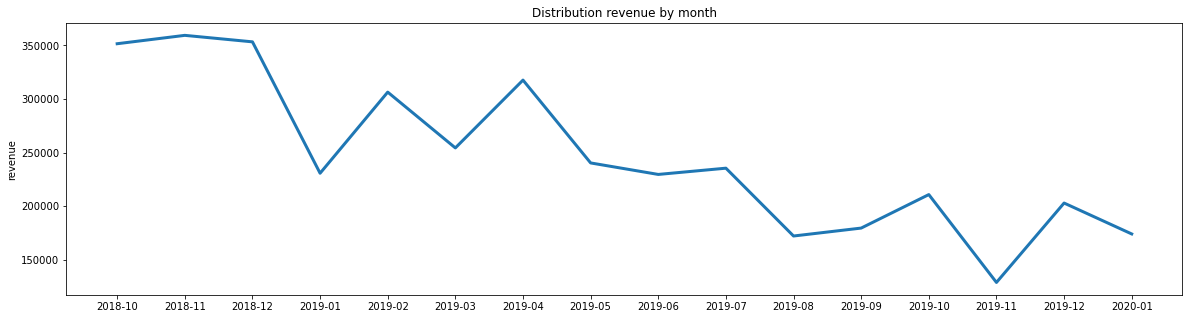

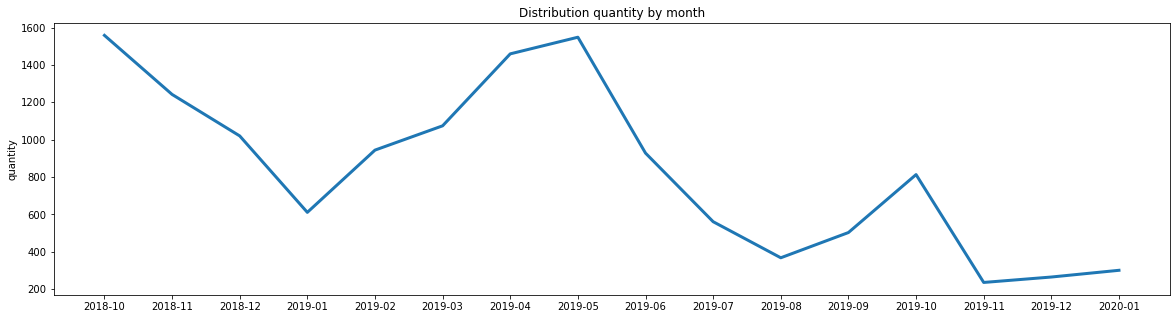

In [29]:
#the data is ready, let's look at interesting data sections.
# let's start with the revenue.
#revenue and number of items in the receipt by date
param =['revenue','quantity']
for i in param:
    quant_month = df.groupby(['month','category'], as_index=False)[i].sum()
    plt.figure(figsize=(20,5))
    plt.title(f'Distribution {i} by month')
    plt.ylabel(i)
    plt.xticks()
    plt.plot(df.groupby('month')[i].sum(), linewidth= 3);

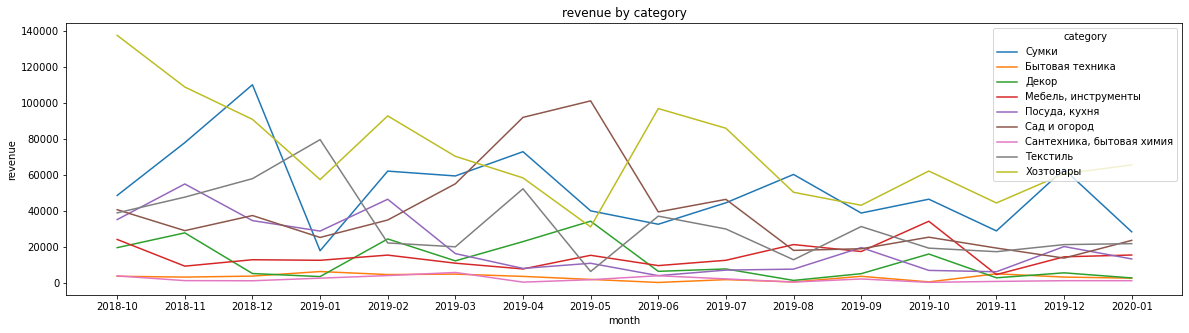

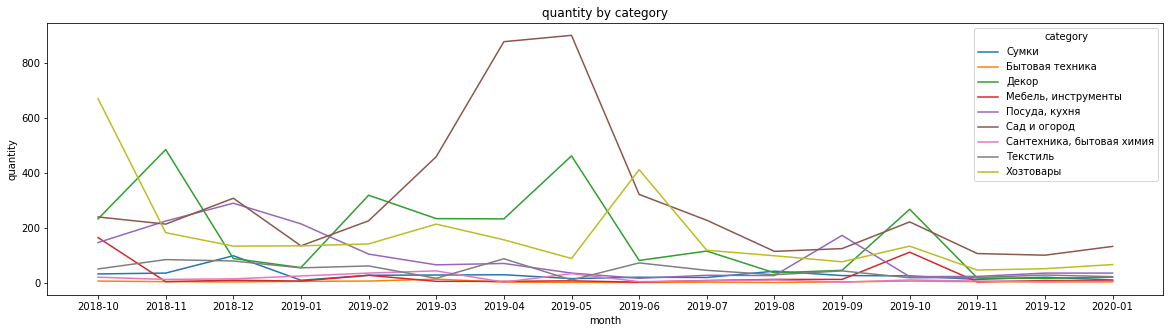

In [30]:
#we see a drop in revenue, the number of items in the receipt is also falling, now let's look at the categories
for i in param:
    cat_month = df.groupby(['month','category'], as_index=False)[i].sum()
    plt.figure(figsize=(20,5))
    plt.title(f'{i} by category')
    sns.lineplot(x=cat_month['month'], y = cat_month[i], hue=cat_month['category']);

* We see a strong drop in revenue in the Household Goods category at the end of 2018. There is a noticeable drop year-on-year (2019 from 2018).
also, this category with the highest revenue, the second is `Garden and vegetable garden` 
* `Garden and vegetable garden" seasonal sales are expected, the peak of which falls on March-May
* in January 2019, the only category that grew was `Textiles`
* * the `bags` category has a large share in revenue and has a fairly stable demand throughout the year
* in November 2019, there was a strong decline in all categories
* "Garden and vegetable garden" - the leader in the number of positions in the receipt

### **Analysis of the number of orders**

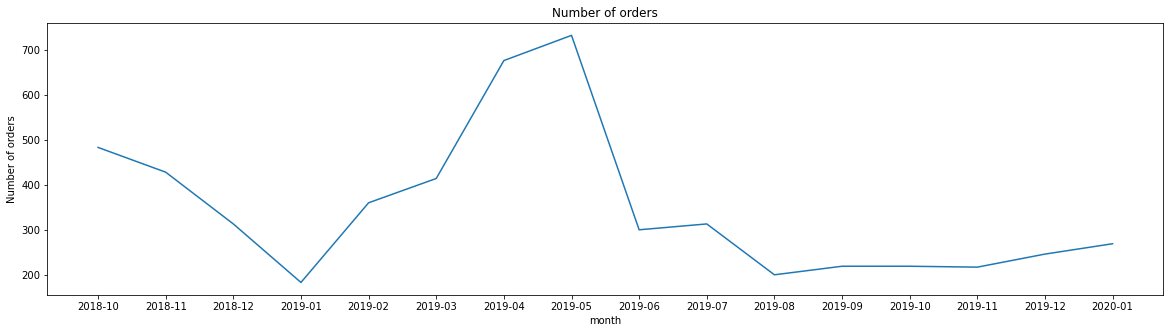

In [31]:
#now let's look at the number of orders
order_month = df.groupby(['month'], as_index=False)['order_id'].count()
plt.figure(figsize=(20,5))
plt.title('Number of orders')
plt.ylabel('Number of orders')
sns.lineplot(x=order_month['month'], y = order_month['order_id']);

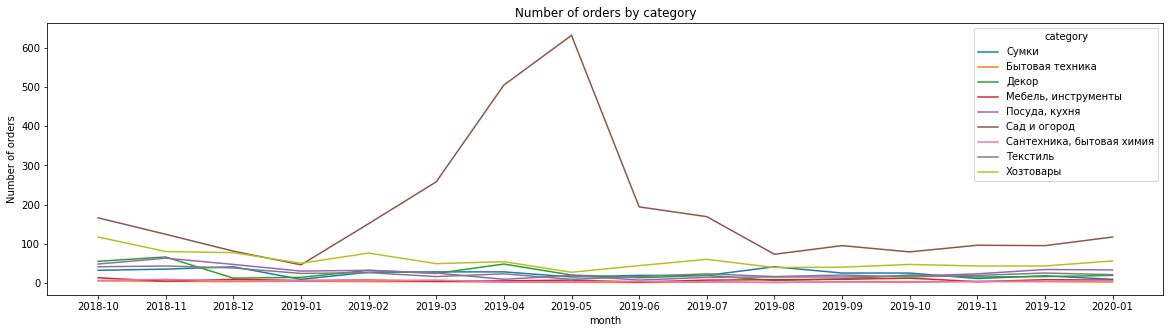

In [32]:
#now let's look at the number of orders by category. The Garden and vegetable garden category smears the picture, let's remove it
order_cat_month = df.groupby(['month', 'category'], as_index=False)['order_id'].count()
plt.figure(figsize=(20,5))
plt.title('Number of orders by category')
plt.ylabel('Number of orders')
sns.lineplot(x=order_cat_month['month'], y = order_cat_month['order_id'], hue=order_cat_month['category']);

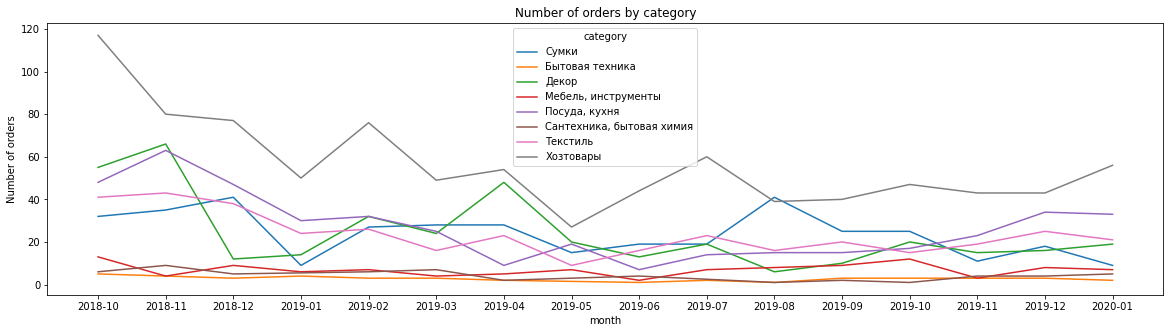

In [33]:
#now let's look at the number of orders without the Garden and Vegetable garden category
order_cat_month = df[df['category'] != 'Сад и огород'].groupby(['month', 'category'], as_index=False)['order_id'].count()
plt.figure(figsize=(20,5))
plt.title('Number of orders by category')
plt.ylabel('Number of orders')
sns.lineplot(x=order_cat_month['month'], y = order_cat_month['order_id'], hue=order_cat_month['category']);

* there was a sharp decrease in the number of orders in January 2019 
* there was also a strong decline in May-June 2019
* * in general, there has been a slight increase in the number of orders since August 2019
* the strongest growth of orders in the categories `Household goods`, `Garden and vegetable garden`

### **Analysis of the average receipt**

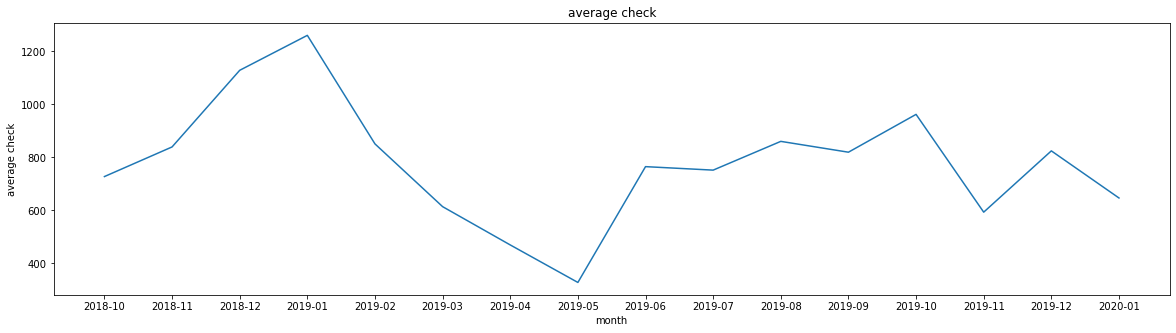

In [34]:
# now let's look at the average check
avg_month = df.groupby(['month'], as_index=False)['revenue'].mean()
plt.figure(figsize=(20,5))
plt.title('average check')
plt.ylabel('average check')
sns.lineplot(x=avg_month['month'], y = avg_month['revenue']);

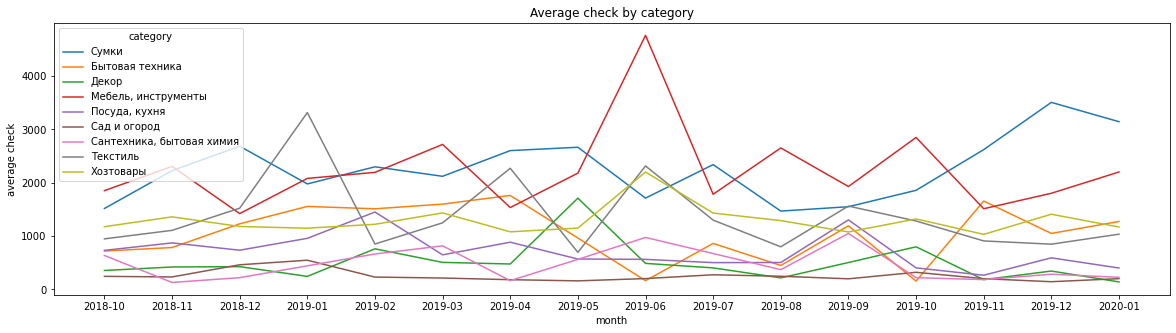

In [35]:
#now let's look at the average check by category
avg_month = df.groupby(['month', 'category'], as_index=False)['revenue'].mean()
plt.figure(figsize=(20,5))
plt.title('Average check by category')
plt.ylabel('average check')
sns.lineplot(x=avg_month['month'], y = avg_month['revenue'], hue=avg_month['category']);

* in May 2019, there was a strong drop in the overall average receipt, while the number of orders increased, apparently there was a seasonal sale
* the average check in June 2019 for the category `Furniture, tools' increased sharply
* in the category of `Bags' the average check is consistently high
* we also see a jump in the average receipt for the Textile category in January 2019

### **Revenue, number of orders, number of customers by category, seasons, Bestsellers**

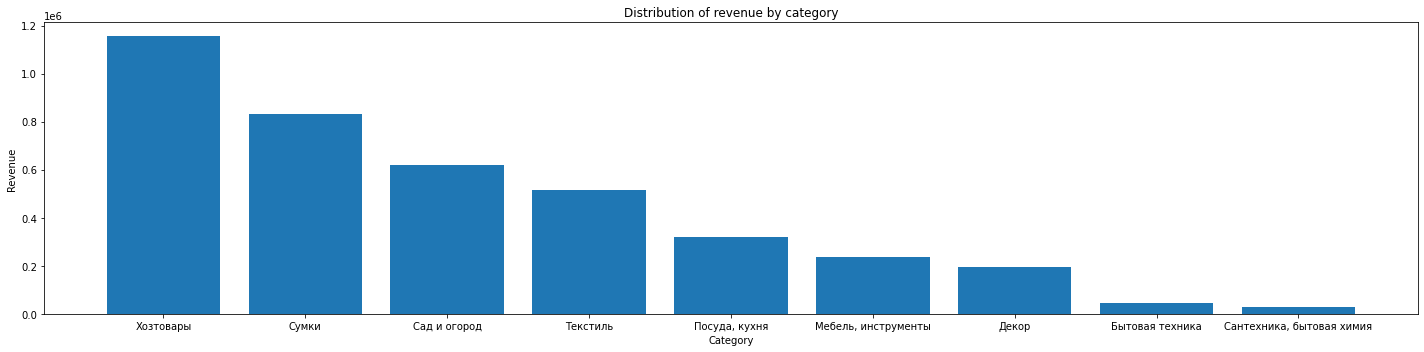

In [36]:
##revenue by category
cat = df.groupby('category', as_index = False)['revenue'].sum().sort_values(by='revenue', ascending=False)
plt.figure(figsize=(20,5))
plt.title('Distribution of revenue by category')
plt.ylabel('Revenue')
plt.xlabel('Category')
plt.tight_layout()
plt.bar(cat['category'], cat['revenue']);

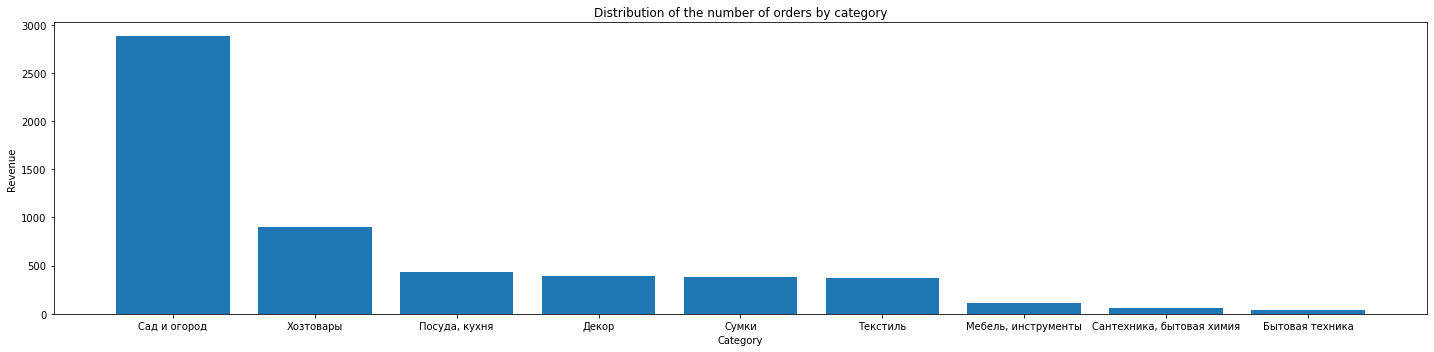

In [37]:
##number of orders by category
cat_order = df.groupby('category', as_index = False)['order_id'].count().sort_values(by='order_id', ascending=False)
plt.figure(figsize=(20,5))
plt.title('Distribution of the number of orders by category')
plt.ylabel('Revenue')
plt.xlabel('Category')
plt.tight_layout()
plt.bar(cat_order['category'], cat_order['order_id']);

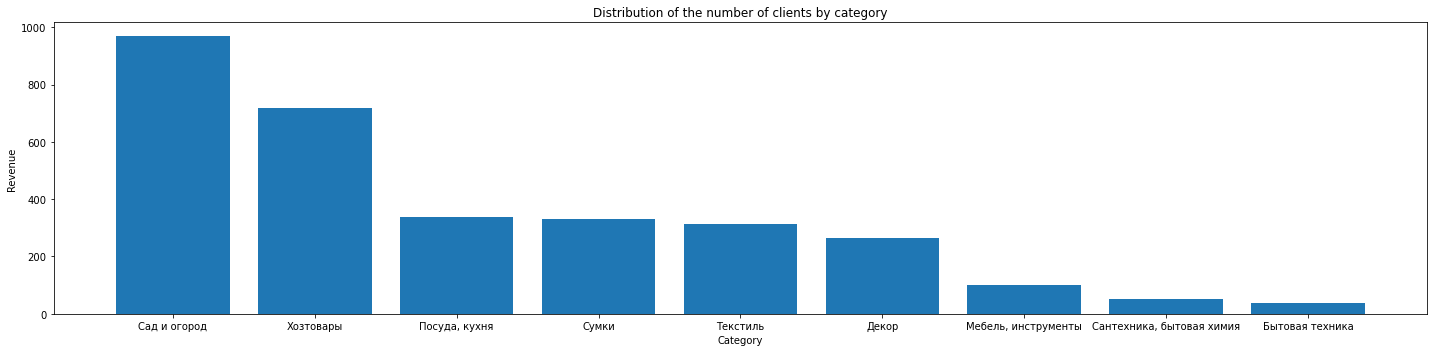

In [38]:
##number of clients by category
cat_custom = df.groupby('category', as_index = False)['customer_id'].nunique().sort_values(by='customer_id', ascending=False)
plt.figure(figsize=(20,5))
plt.title('Distribution of the number of clients by category')
plt.ylabel('Revenue')
plt.xlabel('Category')
plt.tight_layout()
plt.bar(cat_custom['category'], cat_custom['customer_id']);

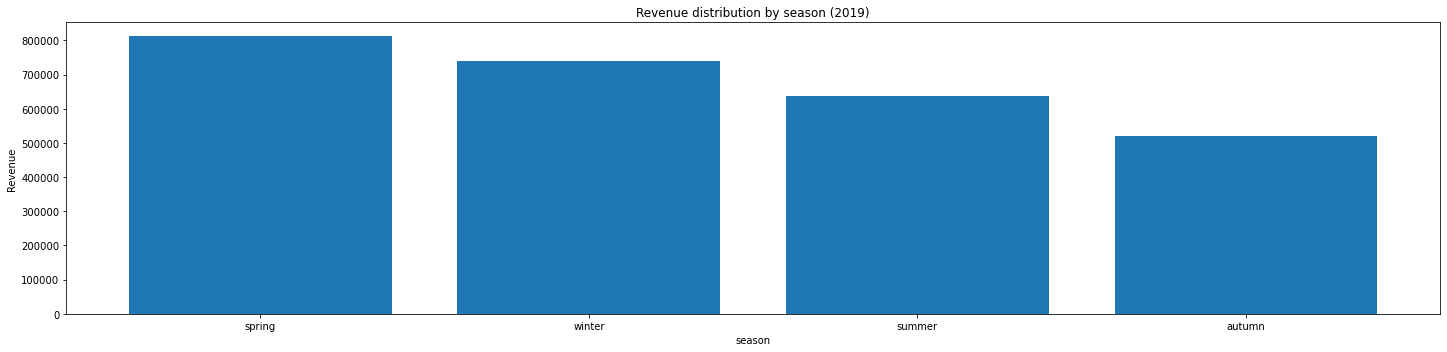

In [39]:
#revenue by season. Since there are complete data on the seasons only for 2019, we will leave only it.
#In spring and winter, the highest revenue.
seas = df[df['date'].dt.year == 2019].groupby('season', as_index=False)['revenue'].sum().sort_values('revenue', ascending=False)
plt.figure(figsize=(20,5))
plt.title('Revenue distribution by season (2019)')
plt.ylabel('Revenue')
plt.xlabel('season')
plt.tight_layout()
plt.bar(seas['season'],seas['revenue']);

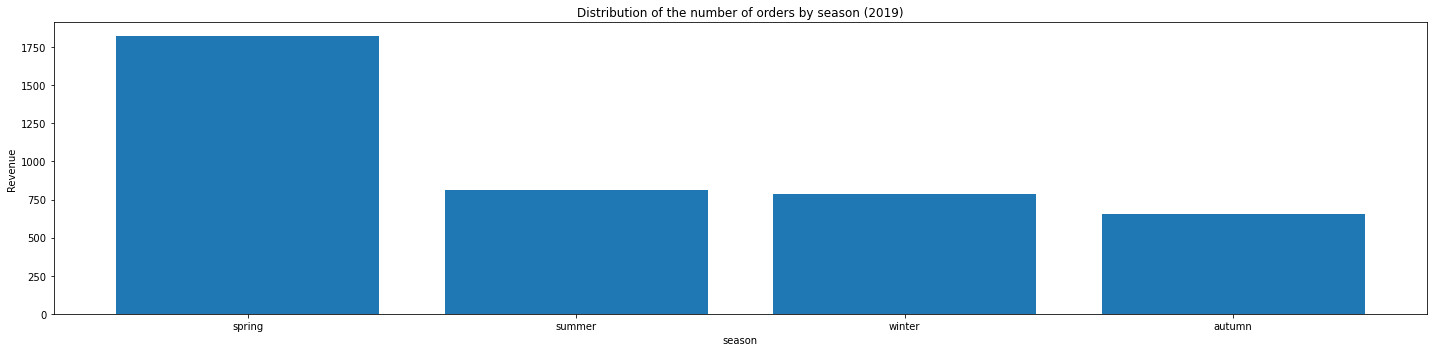

In [40]:
#Since the full data on the seasons is available only for 2019, we will leave only it.
#In spring, the largest number of orders
seas_order = df[df['date'].dt.year == 2019].groupby('season', as_index=False)['order_id'].count().sort_values('order_id', ascending=False)
plt.figure(figsize=(20,5))
plt.title('Distribution of the number of orders by season (2019)')
plt.ylabel('Revenue')
plt.xlabel('season')
plt.tight_layout()
plt.bar(seas_order['season'],seas_order['order_id']);

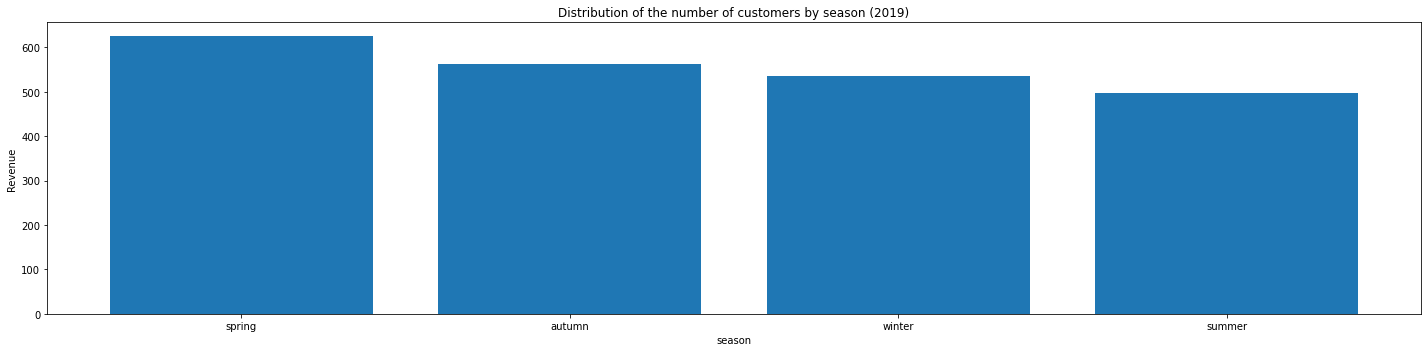

In [41]:
#Since the full data on the seasons is available only for 2019, we will leave only it.
#There is no strong difference in the number of customers by season.
seas_custom = df[df['date'].dt.year == 2019].groupby('season', as_index=False)['customer_id'].nunique().sort_values('customer_id', ascending=False)
plt.figure(figsize=(20,5))
plt.title('Distribution of the number of customers by season (2019)')
plt.ylabel('Revenue')
plt.xlabel('season')
plt.tight_layout()
plt.bar(seas_custom['season'],seas_custom['customer_id']);

In [42]:
#let's look at the TOP popular products by revenue and quantity
display(df.groupby('product')[['revenue','quantity']].sum().sort_values(by=['revenue'], ascending=False).head(5))
display(df.groupby('product')[['revenue','quantity']].sum().sort_values(by=['quantity'], ascending=False).head(5))

,revenue,quantity
product,,
простынь вафельная 200х180 см wellness rw180-01 100% хлопок,53232.0,30
сумка-тележка 2-х колесная gimi argo синяя,50405.0,47
вешалки мягкие для деликатных вещей 3 шт шоколад,49596.0,335
тележка багажная delta тбр-22 синий грузоподъемность 20 кг сумка и 50 кг каркас россия,33992.0,59
муляж яблоко 9 см красное,32702.0,618


,revenue,quantity
product,,
муляж яблоко 9 см красное,32702.0,618
вешалки мягкие для деликатных вещей 3 шт шоколад,49596.0,335
"ручка-скоба рс-100 белая *трибатрон*, 1108035",5829.0,201
муляж яблоко зеленый 9 см полиуретан,10492.0,188
"крепеж для пружины дверной, 1107055",3290.0,170


**Conclusion on the section Research data analysis:**
* total revenue for the store is falling
* the average check sank significantly in May 2019
* the seasonality of the `Garden and vegetable garden' category is visible (March-May)
* revenue in the category of `Textiles` is growing in January (the rest are falling)
* `Household goods`, `Bags` and `Garden and vegetable garden` are the largest categories in terms of revenue
* `Household appliances` and `Plumbing` are the smallest categories by revenue
* The average bill for the category `Furniture and tools` increased in June 2019
* High season - Spring, Low season - Autumn

## **Clustering of clients using machine learning**
    - selection of attributes by which we will cluster (average receipt, number of products, season in the format (1-4), number of orders),
    - standardization of data,
    - building a dendrogram based on customer ids to identify the optimal number of clusters,
    - apply the `k_means` model with the optimal number of clusters (set random_state = 23),
    - compare cluster averages, formulate distinctive features of each cluster's clients
    

### Preparing data and dataset for clustering

In [43]:
##prepare the data for the clustering model. converting a lowercase format to a numeric one
df['season_opt'] = df['date'].apply(lambda x: 1 if 1<=x.month<=2 or x.month == 12 else (2 if 3<=x.month<=5 else (3 if 6<=x.month<=8 else 4)))

In [44]:
##prepare the data for the clustering model. converting a lowercase format to a numeric one
df['category_opt'] = df['category'].apply(lambda x: 1 if x == 'Сад и огород' 
                                      else (2 if x=='Хозтовары' else (3 if x== 'Текстиль' else (4 if x == 'Посуда, кухня'
                                    else (5 if x =='Cумки' else (6 if x == 'Бытовая техника' else (7 if x == 'Декор'
                                    else (8 if x == 'Сантехника, бытовая химия' else 9))))))))

In [45]:
#since the task is to cluster clients, we will group them by clients and specify the necessary attributes for each
#in our case, I suggest clustering according to 6 criteria: the amount of revenue, the number of items in the receipt, the average cost of 1 product, the number of orders
df_customers = df.groupby(['customer_id', 'season_opt', 'category_opt'], as_index=False)[['revenue','quantity','price','order_id']].agg({'revenue':'sum','quantity':'sum','price':'mean','order_id':'count'})
df_customers

,customer_id,season_opt,category_opt,revenue,quantity,price,order_id
0,000d6849-084e-4d9f-ac03-37174eaf60c4,4,1,555.0,4,138.75,4
1,001cee7f-0b29-4716-b202-0042213ab038,1,2,442.0,1,442.00,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,4,3,914.0,2,457.00,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,5,1649.0,1,1649.00,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,4,9,2324.0,2,1162.00,1
...,...,...,...,...,...,...,...
3275,ff601403-b094-4b86-9ac6-264d725b9277,3,5,1649.0,1,1649.00,1
3276,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,4,1,397.0,1,397.00,1
3277,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1,1,389.0,1,389.00,1
3278,ffb80538-3fda-4351-8ea9-9d2bec58bb07,4,4,974.0,1,974.00,1


###  Data standardization and dendrogram construction

In [46]:
# mandatory standardization of data before working with algorithms
sc = StandardScaler()
X_sc = sc.fit_transform(df_customers[['season_opt', 'category_opt', 'revenue','quantity','price','order_id']])
linked = linkage(X_sc, method = 'ward')

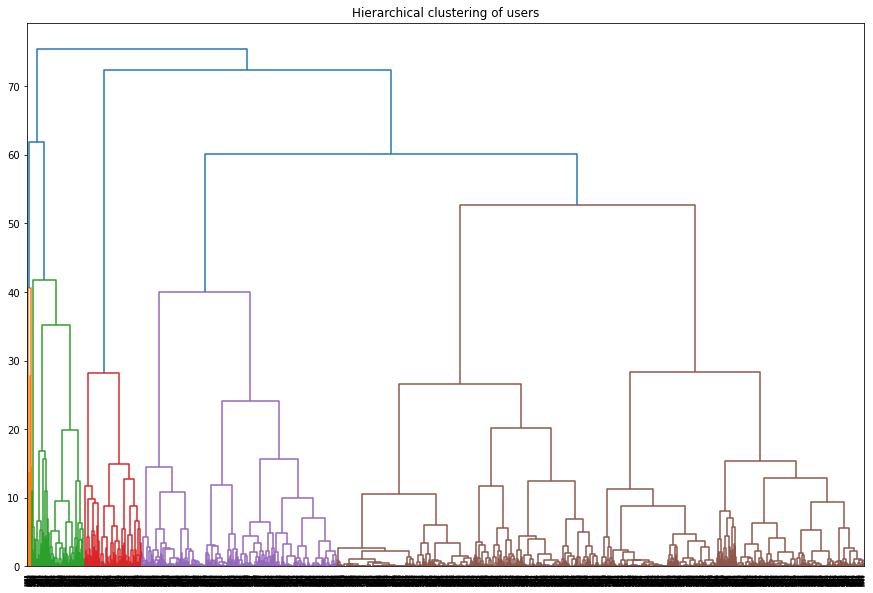

In [47]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering of users')
plt.show()

The dendrogram showed that clients can be divided into 6 clusters

### Using the k-means model

In [48]:
# we set the k_means model with the number of clusters and fix the value of random_state
km = KMeans(n_clusters=6, random_state=23)

# predicting clusters for observations
labels = km.fit_predict(X_sc)

# saving cluster labels in the field of our dataset
df_customers['cluster'] = labels

# we output statistics on the average values of our features for the cluster
print('Comparison of cluster averages')
display(df_customers.groupby('cluster').mean())
print('Comparison of the number of clients by cluster')
display(df_customers.groupby('cluster', as_index = False)['season_opt'].count().sort_values('season_opt', ascending=False))
print('Comparison of revenue by cluster (in millions)')
df_customers2= df_customers.groupby('cluster', as_index = False)['revenue'].sum().sort_values('revenue', ascending=False)
df_customers2['revenue'] = df_customers2['revenue']/1000000
df_customers2

Comparison of cluster averages


,season_opt,category_opt,revenue,quantity,price,order_id
cluster,,,,,,
0,3.692864,2.215899,780.856896,2.656730,493.007547,1.357724
1,2.509804,1.500000,2305.343137,20.068627,139.397417,14.147059
2,1.305491,2.133797,713.229698,2.528229,465.504604,1.297757
3,2.409692,4.215859,4842.143172,1.290749,4061.189060,1.123348
4,2.625000,3.937500,22180.250000,129.375000,637.037840,5.437500
5,2.422430,6.940187,879.989408,5.254206,563.903292,1.132710


Comparison of the number of clients by cluster


,cluster,season_opt
2,2,1293
0,0,1107
5,5,535
3,3,227
1,1,102
4,4,16


Comparison of revenue by cluster (in millions)


,cluster,revenue
3,3,1.099166
2,2,0.922206
0,0,0.864409
5,5,0.470794
4,4,0.354884
1,1,0.235145


At the first glance at the clustering results, we see the distinctive features of clusters:
- `- `0 cluster` - number of customers: 1107, average receipt: 780, average price: 493, average number of orders: 1.3 orders, items in the receipt: 2.6. 

- `- `1 cluster` - number of customers: 102, average receipt: 2305, average price: 139, average number of orders 14 orders, items in the receipt: 20. 

- `- `2 cluster` - number of customers: 1293, average receipt: 713, average price: 465, average number of orders: 1.2 orders, items in the receipt: 2.5. 

- `- `3 cluster` - number of customers: 227, average receipt: 4842, average price: 4061, average number of orders 1.1 orders, items in the receipt: 1.2. 

- `- `4 cluster` - number of customers: 16, average receipt: 22108, average price: 637, average number of orders 5.4 orders, items in the receipt: 129. 

- `- `5 cluster` - number of customers: 535, average receipt: 879, average price: 563, average number of orders: 1.1 orders, positions in the receipt: 5.2. 

Let's take a look at how clusters are broken down by product groups and season

### Analysis of clustering results

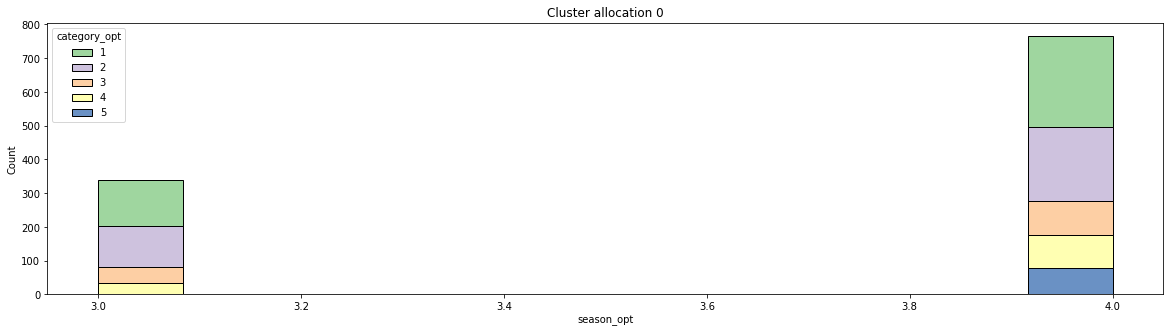

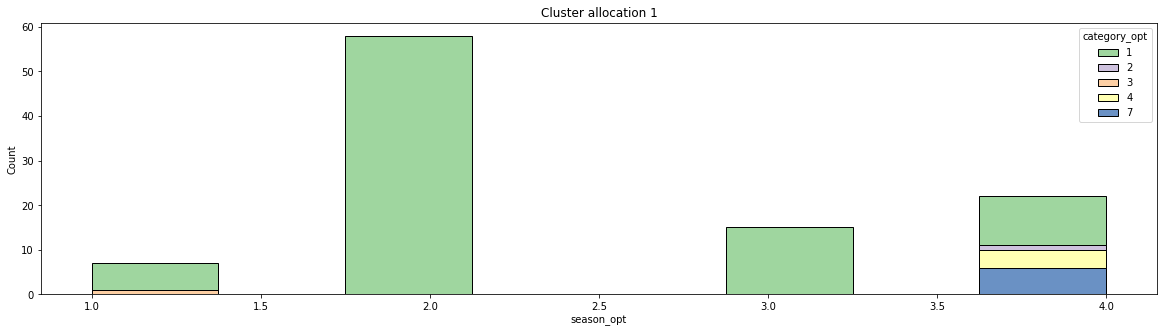

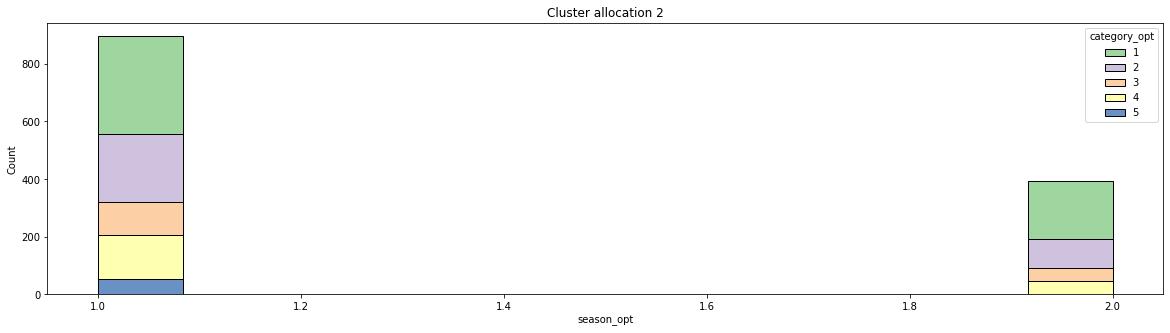

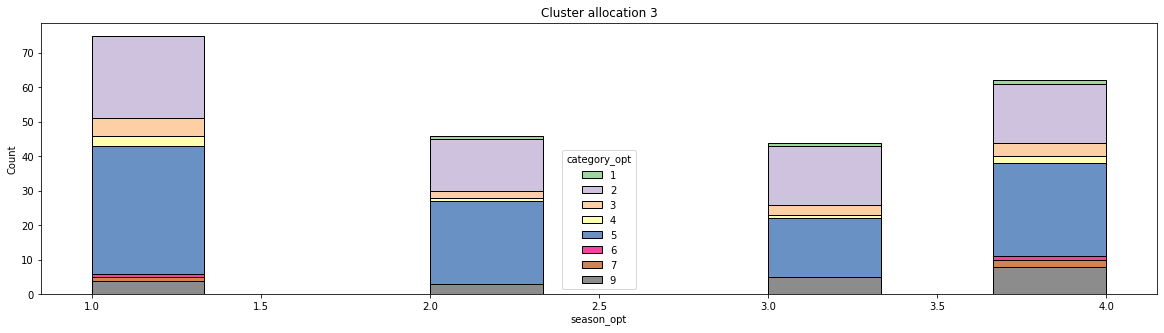

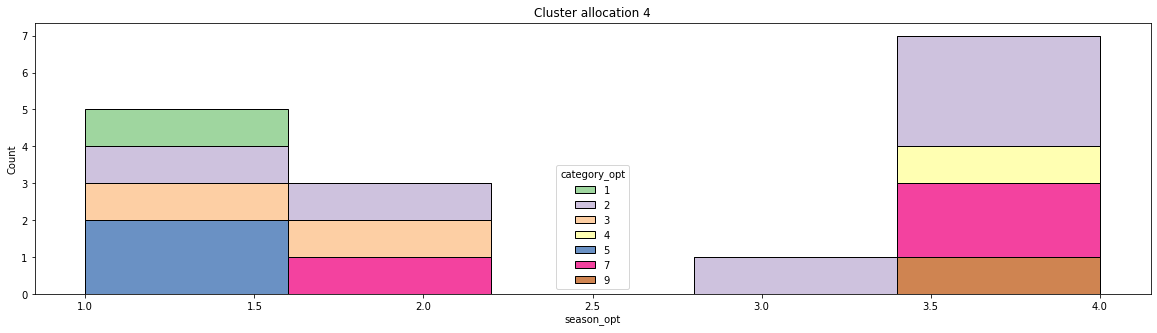

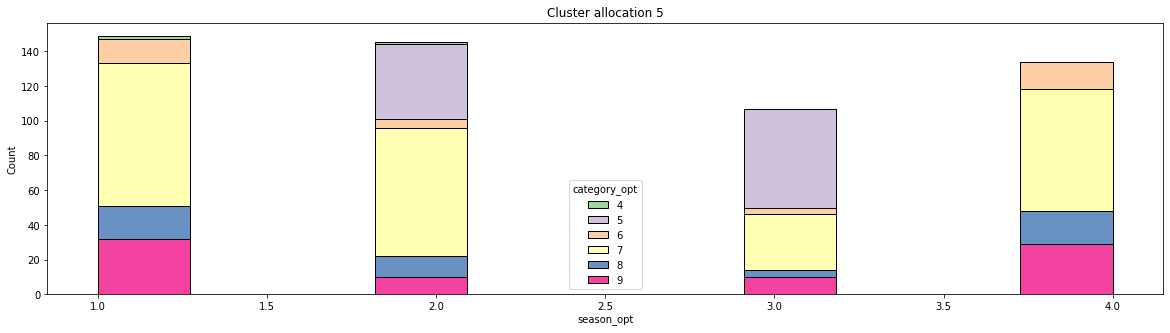

In [49]:
#for convenience, we will build graphs for each cluster, indicating the categories and seasonality for them
category_features = ['category_opt']
for col in category_features:
    for i in range(0,6):
        plt.figure(figsize=(20,5))
        plt.title(f'Cluster allocation {i}')
        sns.histplot(hue= df_customers[df_customers['cluster'] == i][col], x=df_customers[df_customers['cluster'] == i]['season_opt'], palette="Accent",multiple="stack")
        plt.show()

For convenience, let's look at the categories:
1 - 'Garden and vegetable garden',
2 - 'Household goods' 
3 - 'Textiles' 
4 - 'Dishes, kitchen'
5 - 'Bags' 
6 - 'Household appliances' 
7 - 'Decor'
8 - 'Plumbing, household chemicals'
9 - 'Furniture, tools'

- `0 cluster' - Preferred categories: 'Garden and vegetable garden', 'Household goods. Preferred shopping seasons: Summer, Autumn.

- `1 cluster` - More often bought in the spring and according to the category of garden and vegetable garden. 

- `2 cluster' - Categories: Gardening and Household goods. The preferred season is winter and spring. 

- `3 cluster` - More often they buy household goods and bags constantly throughout the year and according to the category. The clients of this cluster bring the most revenue. Preferred season: all year round. 

- `4 cluster' - Preferred categories: Household Goods, Bags, Decor. Preferred seasons: Bags-winter, decor - autumn, Household goods - constant demand all year round.
 
- `5 cluster` - Preferred categories: 'Bags', 'Decor', 'Furniture, tools' Preferred seasons: Spring, Summer for the category of bags and all year round for the other categories.

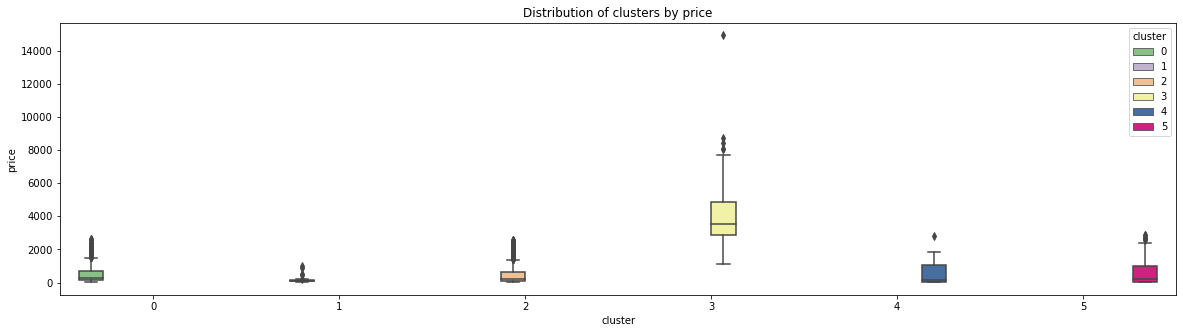

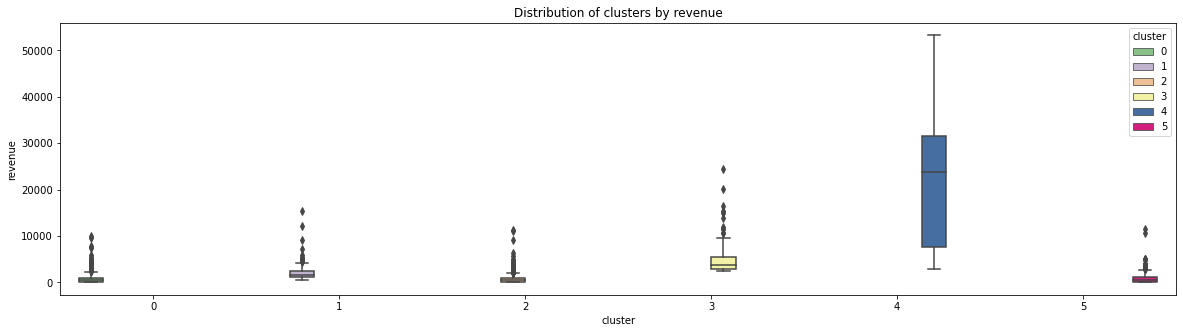

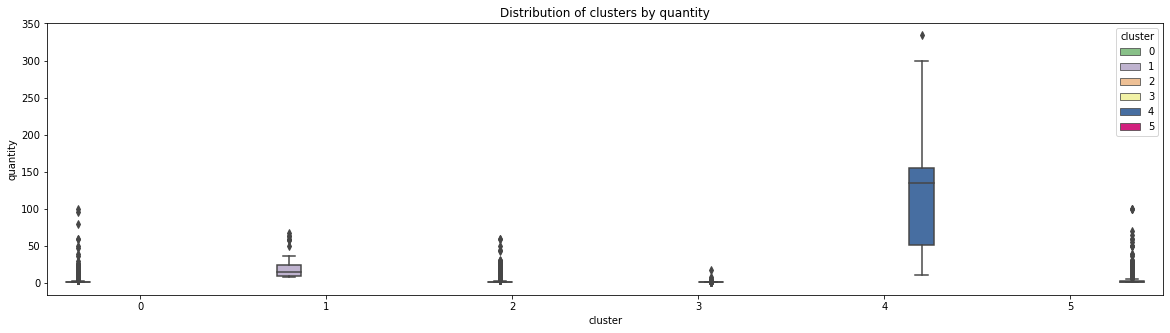

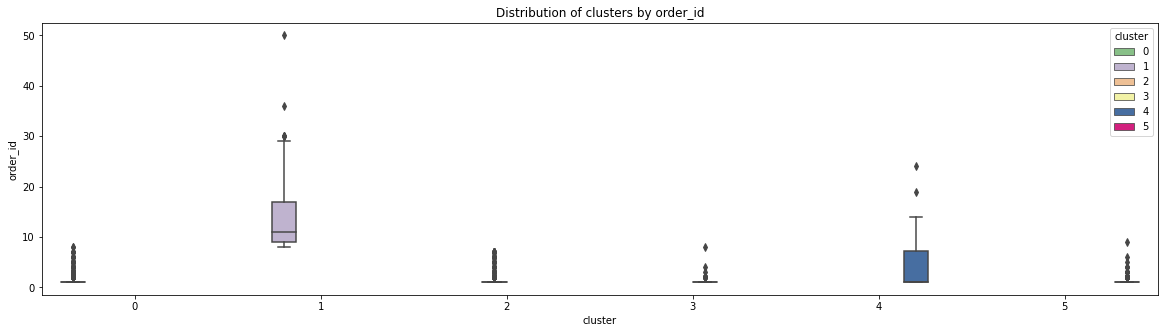

In [50]:
##let's look separately at the distribution of quantitative features by clusters
calc_features = ['price', 'revenue','quantity', 'order_id']
for col in calc_features:
    plt.figure(figsize=(20,5))
    plt.title(f'Distribution of clusters by {col}')
    sns.boxplot(x= df_customers['cluster'], y=df_customers[col], hue=df_customers['cluster'], palette="Accent")
    plt.show()

We went over the quantitative features in paragraph 3.3. above

In [51]:
# let's calculate the silhouette metric for our clustering
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.37


The closer the attribute is to 1, the better clustering is carried out. In this case, the indicator is quite high

#### Dynamics of feature changes by clusters

In [52]:
#creating a shared dataframe with cluster binding
df_merged = df.merge(df_customers, left_on='customer_id', right_on='customer_id')
df_merged.head(2)

,date,customer_id,order_id_x,product,quantity_x,price_x,category,revenue_x,month,season,season_opt_x,category_opt_x,season_opt_y,category_opt_y,revenue_y,quantity_y,price_y,order_id_y,cluster
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,Сад и огород,142.0,2018-10,autumn,4,1,4,1,1037.0,7,148.142857,7,0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,Сад и огород,194.0,2018-10,autumn,4,1,4,1,1037.0,7,148.142857,7,0


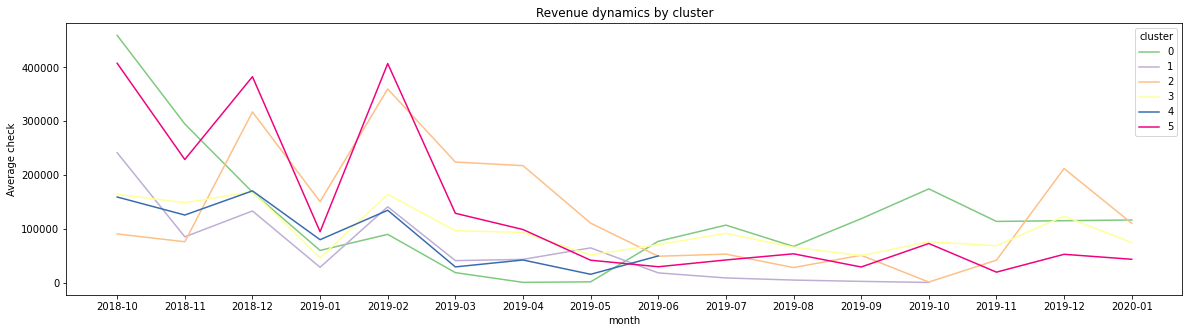

In [53]:
#now let's look at the dynamics of revenue by cluster
clust_month = df_merged.groupby(['month', 'cluster'], as_index=False)['revenue_x'].sum()
plt.figure(figsize=(20,5))
plt.title('Revenue dynamics by cluster')
plt.ylabel('Average check')
sns.lineplot(x=clust_month['month'], y = clust_month['revenue_x'], hue=clust_month['cluster'], palette="Accent");

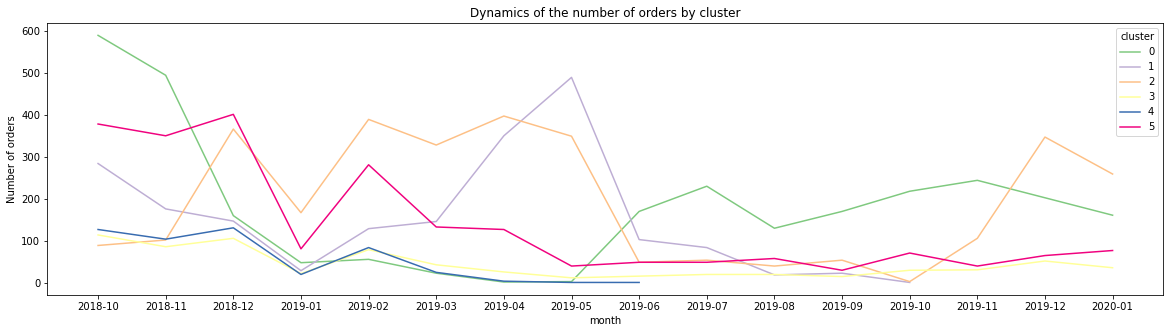

In [54]:
#now let's look at the dynamics of the number of orders by cluster
clust_month = df_merged.groupby(['month', 'cluster'], as_index=False)['order_id_x'].count()
plt.figure(figsize=(20,5))
plt.title('Dynamics of the number of orders by cluster')
plt.ylabel('Number of orders')
sns.lineplot(x=clust_month['month'], y = clust_month['order_id_x'], hue=clust_month['cluster'], palette="Accent");

It is worth paying attention to clusters 5,2,1, for them there is a strong drop in revenue and orders

## **Statistical hypothesis testing**:
- formulation of null and alternative hypotheses:
        -H0 - There are no differences in the average check between clusters,
        -H1 - There are differences in the average check between clusters.
    - - check for stat significant differences in averages (e.g. cf. check) in clusters.

### Hypothesis of equal average checks:
- formulation of null and alternative hypotheses:
        -H0 - There are no differences in the average check between clusters,
        -H1 - There are differences in the average check between clusters.

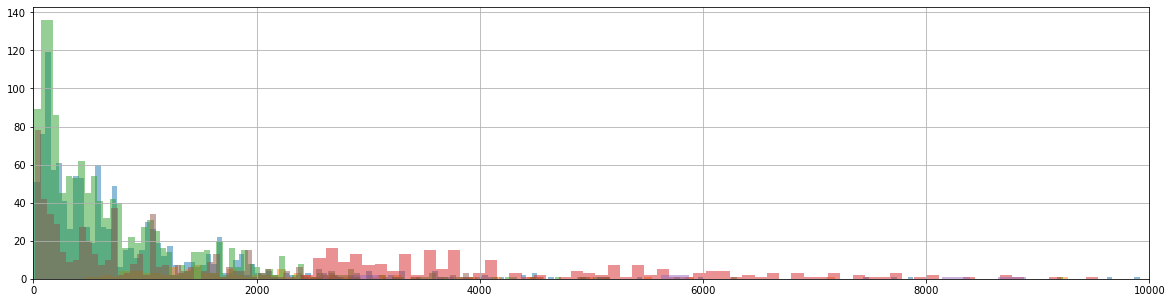

In [55]:
#let's look at the distribution of the revenue attribute. It is noticeable that the distribution is skewed to the right. 
#Thanks to the CPT, if the sample size is at least a few dozen values, the sample averages, 
#which can be obtained from the same general population, will be distributed normally around 
#the true mean of this aggregate.This statement is true even if the general population itself is not distributed normally.

plt.figure(figsize=(20,5))
plt.xlim(0,10000)
for i in range(0,6):
    df_customers.query('cluster == @i')['revenue'].hist(bins=200, alpha=0.5)

In [56]:
##let's check the distributions for normality, if the distributions are not normal, apply a nonparametric test, 
#if normal - parametric

for i in range(0,6):
    #alpha = 1-((1-0.05)**(1/6))
    alpha = 0.05/6

    results = st.shapiro(df_customers.query('cluster == @i')['revenue'])
    p_value = results[1]

    print('p-value: ', p_value)

    if p_value < alpha:
        print(f'For a cluster {i}: We reject the null hypothesis: the distribution is not normal')
        print('_________________')
    else:
        print(f'For a cluster {i}: It was not possible to reject the null hypothesis, everything is normal')
        print('_________________')

p-value:  2.980561833618886e-42
For a cluster 0: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  7.585019106402281e-15
For a cluster 1: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  2.802596928649634e-45
For a cluster 2: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  5.173217923944752e-20
For a cluster 3: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  0.14513178169727325
For a cluster 4: It was not possible to reject the null hypothesis, everything is normal
_________________
p-value:  2.6474980298033347e-30
For a cluster 5: We reject the null hypothesis: the distribution is not normal
_________________


We see that all but 4 clusters are distributed abnormally. 

Since there are small and large samples, and test is more sensitive to the distribution of samples and their sizes, as well as the presence of outliers, the nonparametric mannwhitneyu test is applicable.

In [57]:
##To cross-check all clusters with each other, we will use the combination formula, removing the comparison of clusters with each other.
for i in combinations_with_replacement('012345', 2):
    i_1=int(i[0])
    i_2=int(i[1])
    if i_1 != i_2:
        
        alpha = 0.05/15 # the level of statistical significance if the p-value turns out to be less than it, we reject the hypothesis
                        #since there are 10 hypotheses to reduce the probability of a false positive result,
                        #apply Bonferroni's correction, divide alpha by 15
        
        results = st.mannwhitneyu(df_customers.query('cluster == @i_1')['revenue'].tolist(), 
                               df_customers.query('cluster == @i_2')['revenue'].tolist())
        
        print(f'P-value for the clusters being compared{i[0],i[1]}:, {results.pvalue}')
        if (results.pvalue < alpha):
            print("We reject the null hypothesis")
            print('-------------------------------------------------------')
        else:
            print('We do not reject the null hypothesis')
            print('-------------------------------------------------------')

P-value for the clusters being compared('0', '1'):, 3.7870408614319745e-34
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '2'):, 0.02302645584322665
We do not reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '3'):, 1.9140162810013736e-115
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '4'):, 1.0141725782268976e-11
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '5'):, 0.4344775432886604
We do not reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('1', '2'):, 7.824686138300532e-37
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters be

The resulting p-value indicates that although the average value of revenue is not the same, <b>with a very low probability, such or greater difference can be obtained by chance. </b>P-value is very small compared to alpha, so we can assume that there are differences between the averages.

There are no differences only between clusters 0 and 2, between 0 and 5, and between 2 and 5. However, we saw earlier that there are differences in seasons between 0 and 2 clusters, between 0 and 5 - in product categories, between 2 and 5 - in categories, so there is a need to change clustering or breakdown by there are no categories for obtaining statistically significant results.

### Hypothesis about the equality of the number of orders:
- formulation of null and alternative hypotheses:
        -H0 - There are no differences in the number of orders between clusters,
        -H1 - There are differences in the number of orders between clusters.

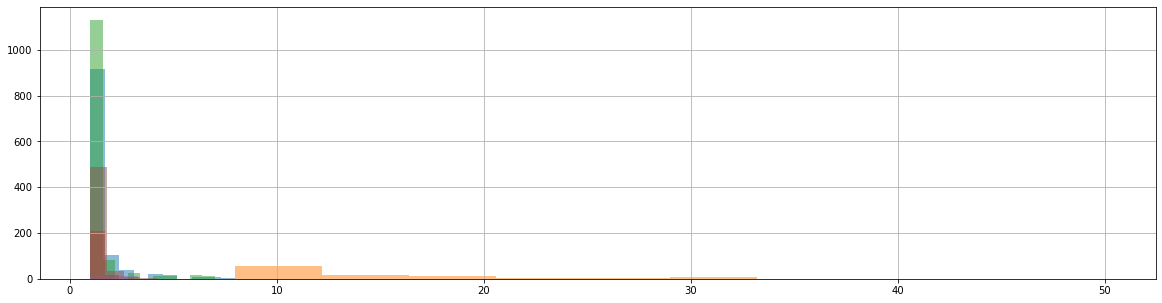

In [58]:
#let's look at the distribution of the quantity of goods attribute. It is noticeable that the distribution is skewed to the right. 
#Thanks to the CPT, if the sample size is at least a few dozen values, the sample averages, 
#which can be obtained from the same general population will be distributed normally around 
#the true mean of this aggregate.This statement is true even if the general population itself is not distributed normally.

plt.figure(figsize=(20,5))
#plt.xlim(0,10000)
for i in range(0,6):
    df_customers.query('cluster == @i')['order_id'].hist(bins = 10, alpha=0.5)

In [59]:
##let's check the distributions for normality, if the distributions are not normal, apply a parametric test, 
#if normal - algebraic

for i in range(0,6):
    alpha = 0.05/6 

    results = st.shapiro(df_customers.query('cluster == @i')['order_id'])
    p_value = results[1]

    print('p-value: ', p_value)

    if p_value<alpha:
        print(f'For cluster {i}: We reject the null hypothesis: the distribution is not normal')
        print('_________________')
    else:
        print(f'For cluster {i}: It was not possible to reject the null hypothesis, everything is fine')
        print('_________________')

p-value:  0.0
For cluster 0: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  2.002044884041876e-11
For cluster 1: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  0.0
For cluster 2: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  7.490317711914223e-30
For cluster 3: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  8.174870890798047e-05
For cluster 4: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  6.080234036705381e-42
For cluster 5: We reject the null hypothesis: the distribution is not normal
_________________


We see that everyone is distributed abnormally. let's conduct a nonparametric test - mannwhitneyu

In [60]:
##To cross-check all clusters with each other, we will use the combination formula, removing the comparison of clusters with each other.
for i in combinations_with_replacement('012345', 2):
    i_1=int(i[0])
    i_2=int(i[1])
    if i_1 != i_2:
        
        alpha = 0.05/15 # the level of statistical significance if the p-value turns out to be less than it, we reject the hypothesis
                        #since there are 15 hypotheses to reduce the probability of a false positive result,
                        #apply Bonferroni's correction, divide alpha by 15
        
        results = st.mannwhitneyu(df_customers.query('cluster == @i_1')['order_id'].tolist(), 
                               df_customers.query('cluster == @i_2')['order_id'].tolist())
        
        print(f'P-value for the clusters being compared{i[0],i[1]}:, {results.pvalue}')
        if (results.pvalue < alpha):
            print("We reject the null hypothesis")
            print('-------------------------------------------------------')
        else:
            print('We do not reject the null hypothesis')
            print('-------------------------------------------------------')

P-value for the clusters being compared('0', '1'):, 2.83063783130671e-109
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '2'):, 0.0013999948355463798
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '3'):, 0.00038518619880518074
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '4'):, 0.0015893476741138234
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '5'):, 5.230220533291373e-07
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('1', '2'):, 1.210452046134036e-133
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compare

The resulting p-value indicates that although the average value of revenue is not the same, <b>with a very low probability, such or greater difference can be obtained by chance. </b>P-value is very small compared to alpha, so we can assume that there are differences between the averages.

There are no differences only between clusters 2 and 3 and between 2 and 5 and between 3 and 5. However, we saw earlier that there are differences in categories between them, so there is no need to change clustering or categorization to obtain statistically significant results. 

### Hypothesis about the equality of the number of positions in the receipt:
    - formulation of null and alternative hypotheses:
        -H0 - There are no differences in the number of items in the receipt between clusters,
        -H1 - There are differences in the number of items in the receipt between clusters.

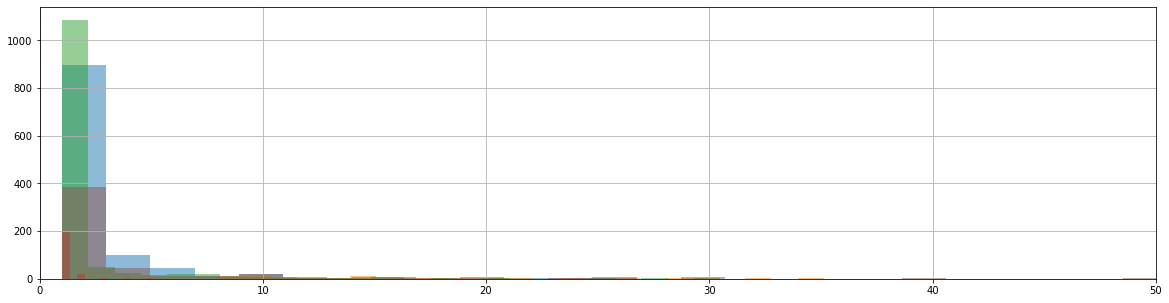

In [61]:
#let's look at the distribution of the attribute number of positions in the receipt. It is noticeable that the distribution is skewed to the right. 
#Thanks to the CPT, if the sample size is at least a few dozen values, the sample averages, 
#which can be obtained from the same general population will be distributed normally around 
#the true mean of this aggregate.This statement is true even if the general population itself is not distributed normally.

plt.figure(figsize=(20,5))
plt.xlim(0,50)
for i in range(0,6):
    df_customers.query('cluster == @i')['quantity'].hist(bins = 50, alpha=0.5)

In [62]:
##let's check the distributions for normality, if the distributions are not normal, apply a parametric test, 
#if normal - algebraic

for i in range(0,6):
    alpha = 0.05/6 

    results = st.shapiro(df_customers.query('cluster == @i')['quantity'])
    p_value = results[1]

    print('p-value: ', p_value)

    if p_value<alpha:
        print(f'For cluster {i}: We reject the null hypothesis: the distribution is not normal')
        print('_________________')
    else:
        print(f'For cluster {i}: Failed to reject null hypothesis, everything is fine')
        print('_________________')

p-value:  0.0
For cluster 0: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  3.4476341920219866e-11
For cluster 1: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  0.0
For cluster 2: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  7.156084607127971e-30
For cluster 3: We reject the null hypothesis: the distribution is not normal
_________________
p-value:  0.14489196240901947
For cluster 4: Failed to reject null hypothesis, everything is fine
_________________
p-value:  1.723913384182923e-38
For cluster 5: We reject the null hypothesis: the distribution is not normal
_________________


In [63]:
##To cross-check all clusters with each other, we will use the combination formula, removing the comparison of clusters with each other.
for i in combinations_with_replacement('012345', 2):
    i_1=int(i[0])
    i_2=int(i[1])
    if i_1 != i_2:
        
        alpha = 0.05/15 # the level of statistical significance if the p-value turns out to be less than it, we reject the hypothesis
                        #since there are 10 hypotheses to reduce the probability of a false positive result,
                        #apply Bonferroni's correction, divide alpha by 15
        
        results = st.mannwhitneyu(df_customers.query('cluster == @i_1')['quantity'].tolist(), 
                               df_customers.query('cluster == @i_2')['quantity'].tolist())
        
        print(f'P-value for the clusters being compared{i[0],i[1]}:, {results.pvalue}')
        if (results.pvalue < alpha):
            print("We reject the null hypothesis")
            print('-------------------------------------------------------')
        else:
            print('We do not reject the null hypothesis')
            print('-------------------------------------------------------')

P-value for the clusters being compared('0', '1'):, 1.3195844207843605e-74
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '2'):, 0.26652289026764187
We do not reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '3'):, 2.9957911836514705e-09
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '4'):, 3.5875871002942493e-16
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('0', '5'):, 6.622561056661304e-05
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being compared('1', '2'):, 1.810816849818351e-77
We reject the null hypothesis
-------------------------------------------------------
P-value for the clusters being c

The resulting p-value indicates that although the average value of revenue is not the same, <b>with a very low probability, such or greater difference can be obtained by chance. </b>P-value is very small compared to alpha, so we can assume that there are differences between the averages.

There are no differences only between clusters 0 and 2. However, we saw earlier that there are differences in seasons between 0 and 2 clusters, so there is no need to change clustering or categorization to obtain statistically significant results.

## Formulation of conclusions and recommendations for marketing promotion

**As a result of the study, the following stages were carried out:**
- - data preprocessing was performed (duplicates were removed, data types were changed)
- - research analysis was carried out (emissions were removed, product categories and additional features were added: season, revenue:
- clustering of customers by revenue, number of orders, average cost of goods, season and category was carried out:
    - 6 clusters have been allocated:    
- - next, a check was carried out for statistically significant differences in features between clusters. In most cases, the difference between clusters has statistical significance, where it does not, there are differences in categorical features (Product category, seasonality).

**Conclusions and patterns:**

- we see that revenue is falling, the average check is recovering after a sharp drop in May 2019
- we see seasonality in the `Garden and vegetable garden` category (March-May)
- we see a drop in sales in the `Household goods` category,
- sales in the "Textiles" category are growing in January, when the other categories are declining,
- it is worth paying attention to the "bags" category. We see stable indicators.
- TOP categories by revenue: `Household goods`, `Bags`, `Garden and vegetable garden`. Minimum categories: `Sanitary ware and household chemicals` and `Household appliances`
- the highest seasons are autumn and winter

**Cluster descriptions and recommendations:**
- `0 cluster' - number of customers: 1107, average receipt: 780, average price: 493, average number of orders 1.3 orders, items in the receipt: 2.6. Let's call them **Frequent buyers with an average receipt**. Preferred categories: 'Garden and vegetable garden', 'Household goods. Preferred shopping seasons: Summer, Autumn.

    - `Recommendations for cluster 0`: to make marketing mailings in the weekdays of spring and summer, to offer products from the categories 'Garden and vegetable garden', 'Household goods' at an average price.


- `1 cluster' - number of customers: 102, average receipt: 2305, average price: 139, average number of orders: 14 orders, items in the receipt: 20. More often they buy a garden and a vegetable garden in the spring and according to the category. Let's call them ** Summer residents - spring **.

    - `Recommendations for cluster 1`: make marketing mailings in the last weeks of winter, offer products from the categories 'Garden and vegetable garden', inexpensive goods, apply promotions, sales.


- `2 cluster' - number of customers: 1293, average receipt: 713, average price: 465, average number of orders 1.2 orders, items in the receipt: 2.5. Categories: Gardening and Household goods. The preferred season is winter and spring. Let's call them ** Summer residents - winter**.
    - `Recommendations for cluster 2`: make marketing mailings in the last weeks of autumn, offer products from the categories of 'Garden and vegetable garden' and household goods, goods of the average price category, apply promotions, sales.


- `3 cluster' - number of customers: 227, average receipt: 4842, average price: 4061, average number of orders 1.1 orders, items in the receipt: 1.2. More often they buy constantly throughout the year and according to the category of household goods and bags. The clients of this cluster bring the most revenue. Preferred season: all year round. Let's call them **Regular customers**.
    - `Recommendations for cluster 3`: make marketing mailings throughout the year, offer goods from the Household goods and bags categories, high-price goods, apply promotions, sales.


- `4 cluster' - number of customers: 16, average receipt: 22108, average price: 637, average number of orders 5.4 orders, items in the receipt: 129. Similar to **wholesale buyers**. Preferred categories: Household Goods, Bags, Decor. Preferred seasons: Bags-winter, decor - autumn, Household goods - constant demand all year round.
    - `Recommendations for cluster 4`: to make wholesale offers in winter (Bags) and autumn (Decor), to offer goods from the Household Goods categories all year round, goods of the average price category.


- `5 cluster' - number of customers: 535, average receipt: 879, average price: 563, average number of orders: 1.1 orders, positions in the receipt: 5.2. Most likely these are **loyal customers**. Preferred categories: 'Bags', 'Decor', 'Furniture, Tools' Preferred seasons: Spring, Summer for the category of bags and all year round for other categories. 
    - `Recommendations for cluster 4': to make marketing mailings throughout the year, by category bags: the last weeks of winter and spring.  offer products from the categories 'Bags', 'Decor', 'Furniture, tools', cheap goods, apply promotions based on the number of purchases.
